### Homework 2

In [1]:
import pandas as pd
import numpy as np
import requests

import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('seaborn')
pd.set_option('display.max_columns',None)

#### 1. Get crypto time series data

In [2]:
def get_data(token):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        },
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT']  # The API above does not have 'FLOW' historical data

df_list = [get_data(token) for token in tokens]
df_base = pd.concat(df_list)

In [4]:
df_base.head()

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH


In [5]:
df_base.tail()  # ends at 2021-12-12

,ts,open,high,low,close,volume,volumeUSD,token
484,2021-12-12 04:00:00,1.0006,1.0006,1.0004,1.0006,2147721.70,2.148902e+06,USDT
485,2021-12-12 05:00:00,1.0006,1.0006,1.0005,1.0005,2788359.89,2.789841e+06,USDT
486,2021-12-12 06:00:00,1.0005,1.0006,1.0005,1.0006,1256389.88,1.257076e+06,USDT
487,2021-12-12 07:00:00,1.0005,1.0006,1.0005,1.0006,1460438.68,1.461209e+06,USDT
488,2021-12-12 08:00:00,1.0005,1.0006,1.0005,1.0005,1746494.03,1.747422e+06,USDT


#### 2. Get the total USD volume & sort from highest to lowest

In [6]:
df_base.groupby('token')['volumeUSD'].sum().to_frame().sort_values(by='volumeUSD', ascending=False)

,volumeUSD
token,
ETH,1.926583e+10
SOL,6.325988e+09
AVAX,3.221265e+09
USDT,1.852674e+09


#### 3. Calculate the close price ratio between ETH and SOL for each period

In [7]:
# join ETH and SOL close price series together
df_close = df_base.loc[df_base['token']=='ETH'].set_index('ts')['close'].rename('close_ETH').to_frame().join(
           df_base.loc[df_base['token']=='SOL'].set_index('ts')['close'].rename('close_SOL').to_frame())

df_close['close_ratio'] = df_close['close_ETH'] / df_close['close_SOL']  # calculcate the close price ratio
df_close.head()

,close_ETH,close_SOL,close_ratio
ts,,,
2021-11-22 00:00:00,4262.99,230.785,18.471694
2021-11-22 01:00:00,4234.37,226.000,18.736150
2021-11-22 02:00:00,4217.89,227.037,18.577985
2021-11-22 03:00:00,4193.47,223.117,18.794937
2021-11-22 04:00:00,4168.35,220.652,18.891059


The `close_ratio` column is the close price ratio between _ETH_ and _SOL_ over each period.

In [8]:
df_base = df_base.join(df_close['close_ratio'], on='ts')  # join the close_ratio time series data to df_base

df_base.head()

,ts,open,high,low,close,volume,volumeUSD,token,close_ratio
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,18.471694
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,18.736150
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,18.577985
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,18.794937
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,18.891059


#### 4. Change the name of the volume and volumeUSD columns to volumeBase and volumeTerm

In [9]:
df_base.rename(
    columns={
    'volume': 'volumeBase',
    'volumeUSD': 'volumeTerm',
    },
    inplace=True)

df_base.head()

,ts,open,high,low,close,volumeBase,volumeTerm,token,close_ratio
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,18.471694
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,18.736150
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,18.577985
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,18.794937
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,18.891059


#### 5. create a table indexed by the timestamp, and each column is the close price of each token

In [10]:
df_close = pd.pivot(df_base, index='ts', columns='token', values='close')
df_close = df_close[tokens]  # sort by tokens order

df_close.head()

token,ETH,SOL,AVAX,USDT
ts,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009


In [11]:
df_close.shape

(489, 4)

#### 6. calculate the hour by hour log return of the close price of each token 

In [12]:
df_base['return'] = df_base.groupby('token')['close'].apply(lambda s: np.log(s).diff())

df_base.head()

,ts,open,high,low,close,volumeBase,volumeTerm,token,close_ratio,return
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,18.471694,NaN
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,18.736150,0.046912
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,18.577985,-0.017279
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,18.794937,0.006318
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,18.891059,0.021583


In [13]:
# get the return time series table
df_return = pd.pivot(df_base, index='ts', columns='token', values='return')[tokens]

df_return.head()

token,ETH,SOL,AVAX,USDT
ts,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,0.046912,-0.006736,-0.020952,0.0001
2021-11-22 02:00:00,-0.017279,-0.003900,0.004578,-0.0001
2021-11-22 03:00:00,0.006318,-0.005806,-0.017417,-0.0001
2021-11-22 04:00:00,0.021583,-0.006008,-0.011109,-0.0002


Generally, We can use `df_return.dropna()` or `df_return.fillna(0)` to handle with the NaN value for further analysis.

#### 7. Calculate the correlation among assets

In [14]:
df_corr = df_return.corr()  # correlation matrix
df_corr

token,ETH,SOL,AVAX,USDT
token,,,,
ETH,1.000000,0.638025,0.620202,-0.021198
SOL,0.638025,1.000000,0.734902,-0.126400
AVAX,0.620202,0.734902,1.000000,0.110430
USDT,-0.021198,-0.126400,0.110430,1.000000


#### 8. Visualize the correlation

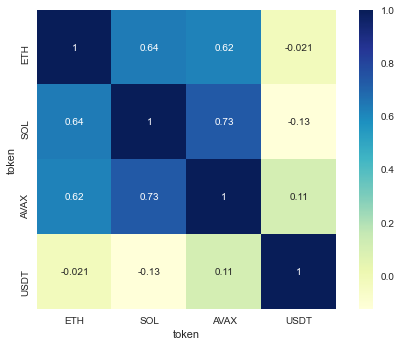

In [15]:
fig = sns.heatmap(df_corr, cmap="YlGnBu", square=True, annot=True)

Basic findings:

+ _ETH_, _SOL_ and _AVAX_ have strong correlations with each other
+ _USDT_ has little correlation with other 3 tokens 